# Assessment of model performance for high confidence predictions
Required inputs: `activity_summary_stats_and_metadata.txt`

Output: `predictedObservedClasses_{confident,random}.svg`, violin plots of the observed activity for high confidence predictions, stratified by their predicted activity. Bonus plot is generated for the randomly sampled sequences, but this figure is not used.

In [1]:
import os
import sys

import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, confusion_matrix

from src.mpra_tools import loaders, plot_utils, modeling
from src.selene_files.enhancer_model import EnhancerModel

data_dir = "Data"
figures_dir = "Figures"
plot_utils.set_manuscript_params()

/ref/bclab/software/ryan/.conda/envs/active-learning/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load in the data and extract the high confidence and randomly sampled sequences. Also load in the CNN trained through Round 3b to obtain predicted activities. This represents the learning round at which the high confidence predictions were made. Both the high confidence and randomly sampled sequences are scored against this CNN to enable a direct comparison between the two groups.

In [2]:
activity_df = loaders.load_data(
    os.path.join(data_dir, "activity_summary_stats_and_metadata.txt")
)
activity_df = activity_df[
    activity_df["data_batch_name"].isin(["HighConfidence", "Round3c"])
]
model = loaders.load_cnn(
    os.path.join("ModelFitting", "CNN_Clf", "Round3bFull", "Round3b", "1", "best_model.pth.tar"),
    EnhancerModel(164, 4)
)
# Define the sort order for the four activity bins
class_sort_order = ["Silencer", "Inactive", "WeakEnhancer", "StrongEnhancer"]

## Make predictions
For each group, make predictions and return the predicted class, the probability, and the entropy (uncertainty) of the predictions.

In [3]:
def predict_group(df):
    seqs = modeling.one_hot_encode(df["sequence"])
    seqs_batched = modeling.batch(seqs)
    preds = modeling.cnn_predict_batches(model, seqs_batched)
    preds_df = pd.DataFrame(preds, index=df.index, columns=class_sort_order)
    # Go from log prob to probability
    preds_df = preds_df.apply(np.exp)
    results = pd.concat({
        "pred": preds_df.idxmax(axis=1),
        "prob": preds_df.max(axis=1),
        "entropy": preds_df.apply(stats.entropy, base=2, axis=1)
    }, axis=1)
    return results

In [4]:
grouper = activity_df.groupby("data_batch_name", group_keys=True)
predictions = grouper.apply(predict_group).rename(
    index={"HighConfidence": "Confident", "Round3c": "Random"},
    level="data_batch_name"
)
loaders.write_data(predictions, os.path.join(data_dir, "high_confidence_predictions.txt"))

Show differences in the entropy of the two groups.

data_batch_name,Confident,Random
count,2055.000000,6335.000000
mean,1.240836,1.508402
std,0.685251,0.548551
min,0.003388,0.018915
25%,1.323520,1.192513
50%,1.587993,1.771754
75%,1.667596,1.919883
max,1.960990,1.999917


Text(0.5, -4.588190444444445, 'Data batch')

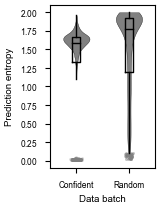

In [5]:
grouper = predictions.groupby("data_batch_name")["entropy"]
display(grouper.describe().T)
fig = plot_utils.violin_plot_groupby(
    grouper,
    "Prediction entropy",
    figax=plt.subplots(figsize=plot_utils.get_figsize(0.25, 1.2)),
)
ax = fig.axes[0]
ax.set_xlabel("Data batch")

## Now report the accuracy of those predictions

Helper function that takes the predicted labels and observed data, makes a violin plot and reports various measures of accuracy.

In [6]:
def plot_report_accuracy(df, preds, title):
    print(title)
    preds = pd.Categorical(preds, categories=class_sort_order, ordered=True)
    grouper = df.groupby(preds)
    
    # fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.33, 1))
    # fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.33, 0.8))
    fig, ax = plt.subplots(figsize=plot_utils.get_figsize(0.27, 1))
    fig = plot_utils.violin_plot_groupby(
        grouper["expression_log2"],
        "Observed activity",
        class_names=["Silencer", "Inactive", "Weak\nenh.", "Strong\nenh."],
        class_colors=plot_utils.get_class_colors(),
        figax=(fig, ax),
    )
    
    # Calculate main accuracy metric
    observed_bin = df["activity_bin"]
    score = f1_score(
        observed_bin,
        preds,
        average="weighted",
    )
    
    ax.set_xlabel("Predicted activity")
    for y in [-1, 1, loaders.get_strong_cutoff()]:
        ax.axhline(y, color="k", lw=1, linestyle="--")

    # Check a few other metrics of accuracy
    print("Micro F1 score:")
    print(f1_score(
        observed_bin,
        preds,
        average="micro"
    ))
    print("Weighted F1 score:")
    print(score)
    print("Macro F1 score:")
    print(f1_score(
        observed_bin,
        preds,
        average="macro"
    ))
    print("Per-class F1 score:")
    print(f1_score(
        observed_bin,
        preds,
        average=None,
        labels=class_sort_order,
    ))
    
    confusion = confusion_matrix(observed_bin, preds, normalize="all")
    print("Confusion matrix:")
    print(confusion)
    print(f"{np.diagonal(confusion).sum() * 100}% are correct (should be same as micro F1).")
    off_by_one = np.diagonal(confusion, offset=1).sum() + np.diagonal(confusion, offset=-1).sum()
    print(f"{off_by_one * 100}% are off by one class.")
    
    # Make sure all figures have the same axis
    ax.set_ylim((-7.9, 7.3))
    
    ax.set_title("High Confidence Predictions")
    
    return fig, ax

Confident
Micro F1 score:
0.7187347931873479
Weighted F1 score:
0.7179429231542274
Macro F1 score:
0.539651371486193
Per-class F1 score:
[0.92584655 0.2735426  0.29166667 0.66754967]
Confusion matrix:
[[2.96836983e-02 7.78588808e-03 2.62773723e-02 7.15328467e-02]
 [4.08759124e-02 5.25547445e-01 6.32603406e-03 2.62773723e-02]
 [4.86618005e-04 9.73236010e-04 1.22627737e-01 5.83941606e-03]
 [1.07055961e-02 1.94647202e-03 8.22384428e-02 4.08759124e-02]]
71.8734793187348% are correct (should be same as micro F1).
14.403892944038931% are off by one class.
Random
Micro F1 score:
0.35690607734806623
Weighted F1 score:
0.30903544532827
Macro F1 score:
0.3083037249955413
Per-class F1 score:
[0.27637722 0.31385745 0.13157895 0.51140129]
Confusion matrix:
[[0.08097869 0.04072612 0.15201263 0.04988161]
 [0.07719021 0.04672455 0.0715075  0.03188635]
 [0.00694554 0.00299921 0.20710339 0.00820837]
 [0.0273086  0.02036306 0.15406472 0.02209945]]
35.690607734806626% are correct (should be same as micro 

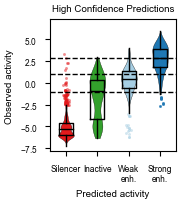

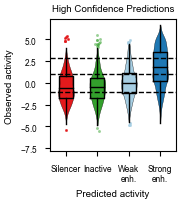

In [7]:
for batch, df in predictions.groupby("data_batch_name"):
    df = df.reset_index(level="data_batch_name")
    # Get the corresponding measurement info
    batch_measured = activity_df.loc[df.index]
    fig, ax = plot_report_accuracy(batch_measured, df["pred"], batch)
    plot_utils.save_fig(fig, os.path.join(figures_dir, f"predictedObservedClasses_{batch}"))